##Variational Autoencoder (VAE)

A Variational Autoencoder (VAE) is a type of neural network that learns to compress data into a lower-dimensional space (latent space) and then reconstruct it. It is widely used in image generation, anomaly detection, and representation learning.

Traditional autoencoders can compress and reconstruct data, but they don’t learn a structured latent space.

* VAEs learn a continuous and structured latent space, making it useful for:
* Generating new data (e.g., creating new images similar to training data).
* Interpolating between data points.
* Handling noisy or missing data.


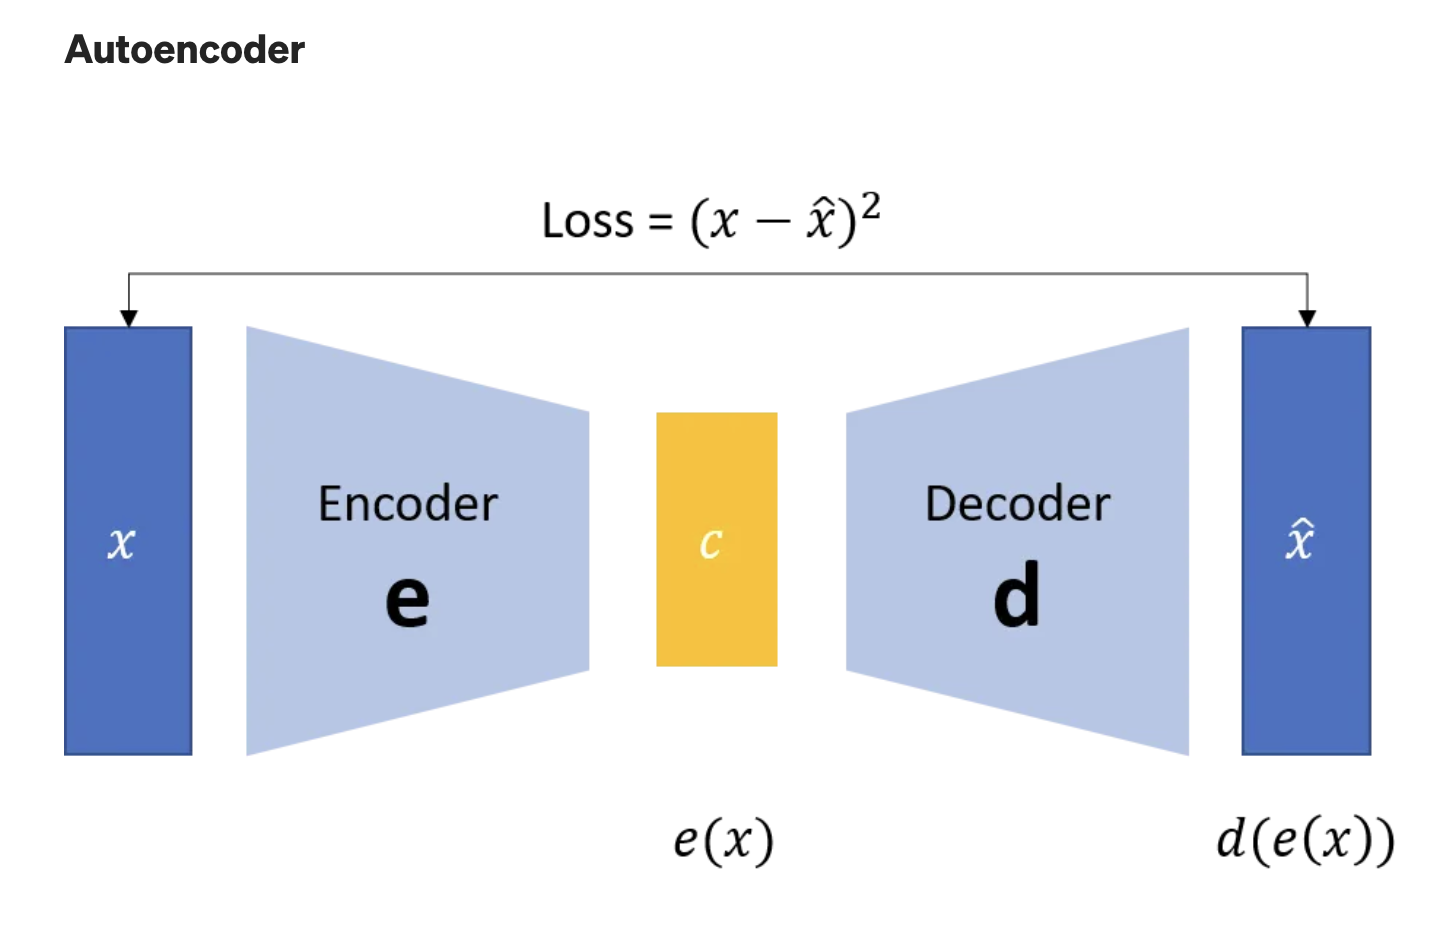

##Traditional Autoencoders:
A traditional autoencoder consists of:

An encoder that compresses input X into a lower-dimensional representation Z.

A decoder that reconstructs X'from Z.

However, traditional autoencoders suffer from a major limitation:
* They learn a fixed deterministic mapping, meaning each input is mapped to a single latent point.
* They do not learn a structured latent space, making them unsuitable for generating new data or smooth interpolation between points.

Why Use VAEs?

VAEs solve this problem by:

* Learning a probability distribution instead of a fixed latent representation.

* Ensuring that similar data points are mapped close together in latent space.

* Making the model capable of generating new samples by sampling from this learned distribution.

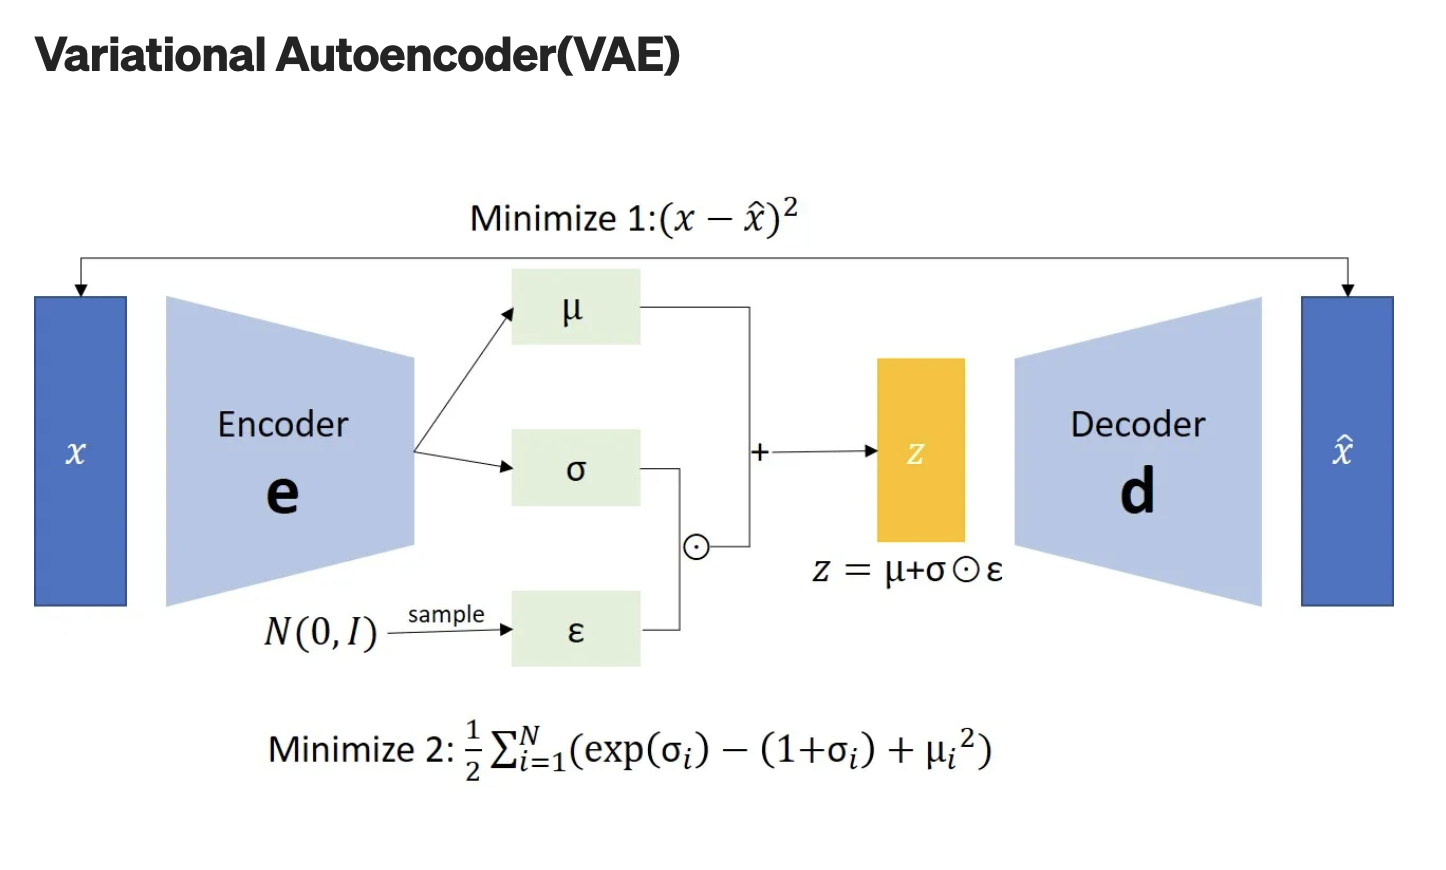

A VAE consists of three main components:

## Encoder:
Compresses the input into a probability distribution in the latent space.
Encoder in VAEs
Instead of learning a single latent vector z, a VAE learns:

A mean vector μ → Determines the center of the distribution.

A variance vector → Determines the spread of the distribution.

The encoder learns these parameters so that similar inputs map to nearby regions in latent space.

## Reparameterization Trick:

Allows sampling while keeping the model differentiable.

Why Is This Necessary?
To train a neural network, we need to compute gradients using backpropagation.

However, sampling z directly from the distribution is non-differentiable.

If we cannot compute gradients, the model cannot learn properly.

Instead of sampling directly, we rewrite z using a deterministic function.This allows gradients to flow since we now sample ϵ from a fixed normal distribution.

## Decoder:
Reconstructs the input from the sampled latent vector.

Reconstruction Loss : Measures how well the decoder reconstructs X' from Z.

KL Divergence Loss (Regularization):Encourages the latent space to follow a standard normal distribution




In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
batch_size = 128
learning_rate = 1e-3
num_epochs = 20
latent_dim = 20

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        x = x.view(x.size(0), -1)

        mu, logvar = self.encode(x)

        z = self.reparameterize(mu, logvar)

        reconstructed = self.decode(z)

        return reconstructed, mu, logvar

In [ ]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross entropy)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [ ]:
def train(epoch):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')


In [ ]:
def test(epoch):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    return test_loss

Train Epoch: 1 [0/60000 (0%)]	Loss: 110.687492
Train Epoch: 1 [12800/60000 (21%)]	Loss: 108.775421
Train Epoch: 1 [25600/60000 (43%)]	Loss: 111.042984
Train Epoch: 1 [38400/60000 (64%)]	Loss: 107.250755
Train Epoch: 1 [51200/60000 (85%)]	Loss: 111.057487
====> Epoch: 1 Average loss: 110.0215
====> Test set loss: 108.5329


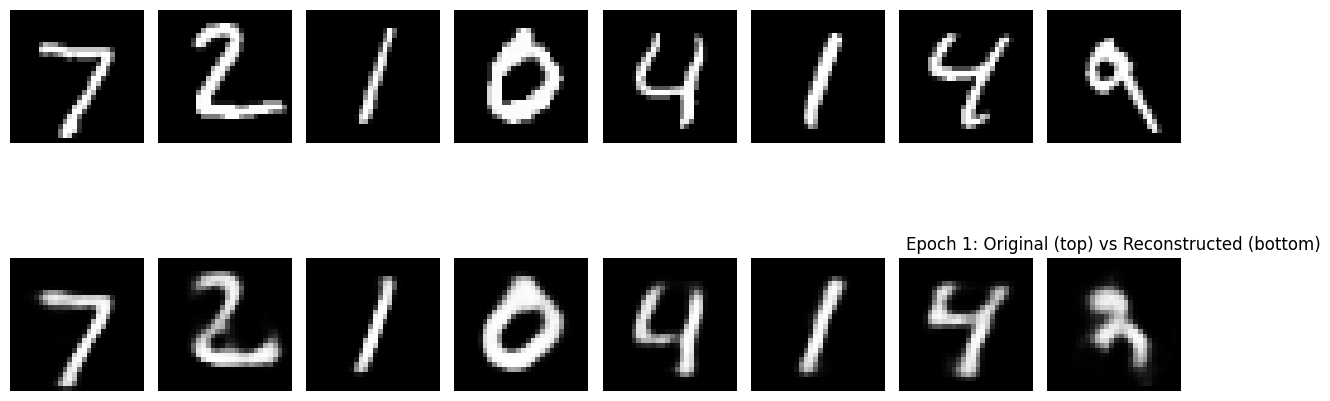

Train Epoch: 2 [0/60000 (0%)]	Loss: 111.931870
Train Epoch: 2 [12800/60000 (21%)]	Loss: 112.926376
Train Epoch: 2 [25600/60000 (43%)]	Loss: 110.795197
Train Epoch: 2 [38400/60000 (64%)]	Loss: 109.141830
Train Epoch: 2 [51200/60000 (85%)]	Loss: 107.846611
====> Epoch: 2 Average loss: 108.8905
====> Test set loss: 107.8176


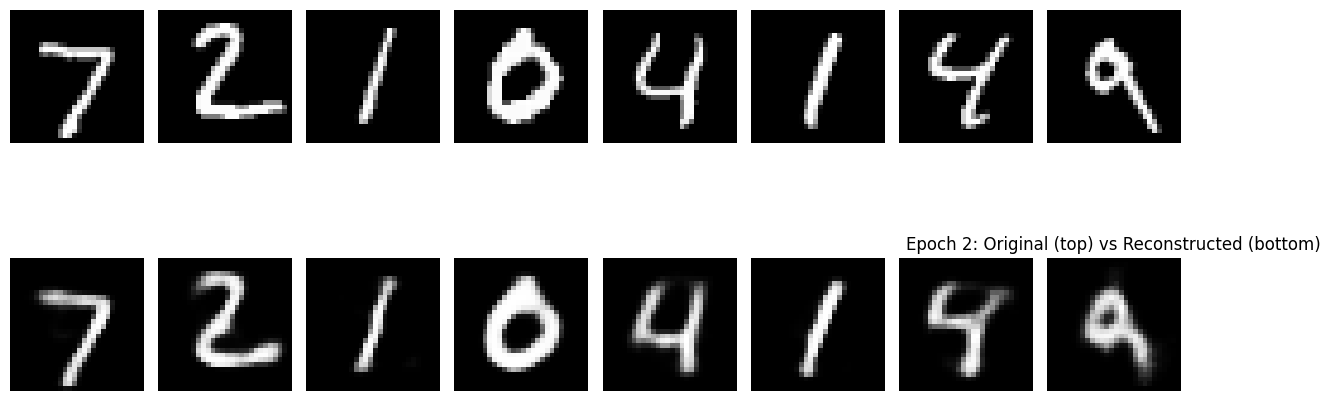

Train Epoch: 3 [0/60000 (0%)]	Loss: 107.620293
Train Epoch: 3 [12800/60000 (21%)]	Loss: 110.042603
Train Epoch: 3 [25600/60000 (43%)]	Loss: 105.027679
Train Epoch: 3 [38400/60000 (64%)]	Loss: 105.321434
Train Epoch: 3 [51200/60000 (85%)]	Loss: 105.793152
====> Epoch: 3 Average loss: 107.9622
====> Test set loss: 107.0526


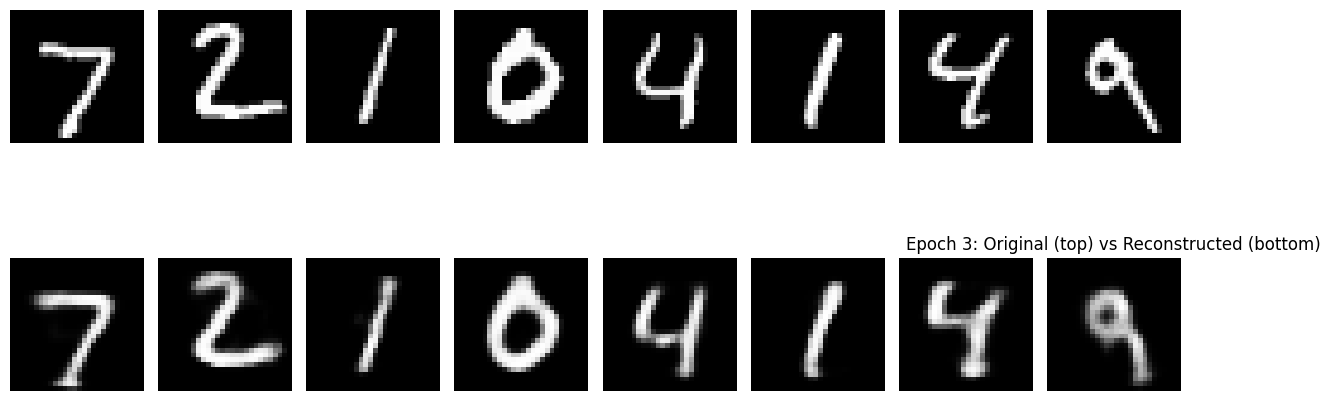

Train Epoch: 4 [0/60000 (0%)]	Loss: 108.727249
Train Epoch: 4 [12800/60000 (21%)]	Loss: 104.436775
Train Epoch: 4 [25600/60000 (43%)]	Loss: 107.225571
Train Epoch: 4 [38400/60000 (64%)]	Loss: 105.179474
Train Epoch: 4 [51200/60000 (85%)]	Loss: 104.929825
====> Epoch: 4 Average loss: 107.3513
====> Test set loss: 106.5221


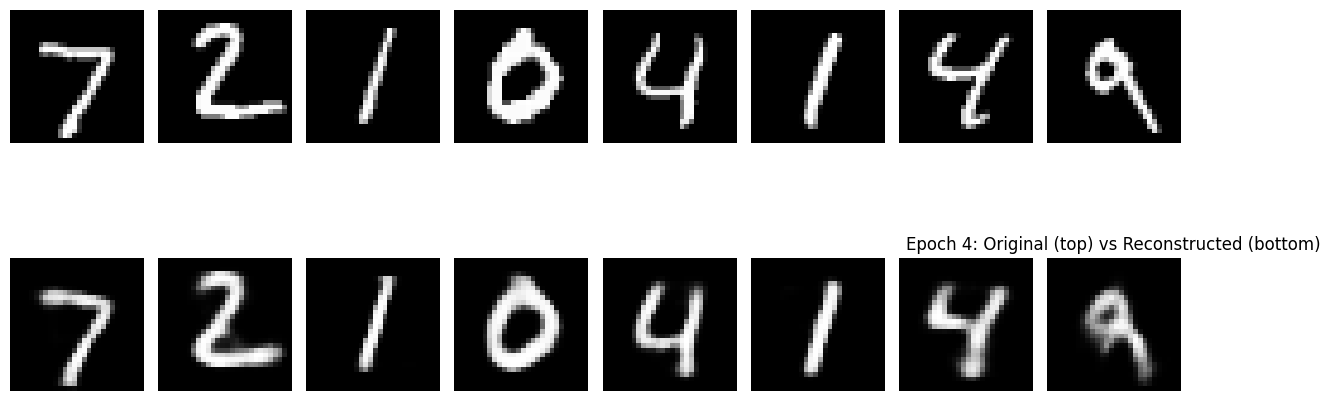

Train Epoch: 5 [0/60000 (0%)]	Loss: 110.130280
Train Epoch: 5 [12800/60000 (21%)]	Loss: 107.510971
Train Epoch: 5 [25600/60000 (43%)]	Loss: 107.652985
Train Epoch: 5 [38400/60000 (64%)]	Loss: 111.057388
Train Epoch: 5 [51200/60000 (85%)]	Loss: 102.876862
====> Epoch: 5 Average loss: 106.8462
====> Test set loss: 106.5108


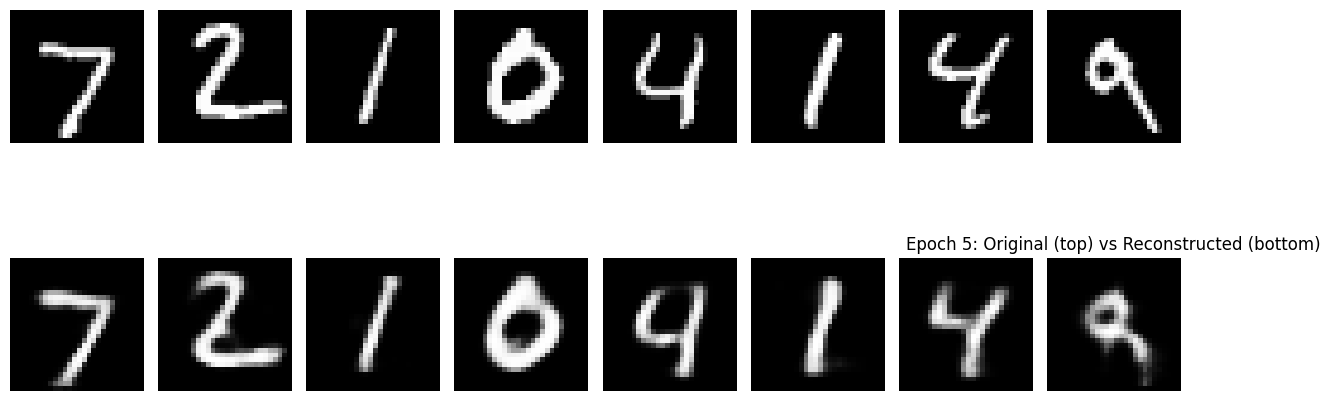

Train Epoch: 6 [0/60000 (0%)]	Loss: 106.068665
Train Epoch: 6 [12800/60000 (21%)]	Loss: 106.758408
Train Epoch: 6 [25600/60000 (43%)]	Loss: 104.982651
Train Epoch: 6 [38400/60000 (64%)]	Loss: 108.723679
Train Epoch: 6 [51200/60000 (85%)]	Loss: 107.797417
====> Epoch: 6 Average loss: 106.4118
====> Test set loss: 105.9772


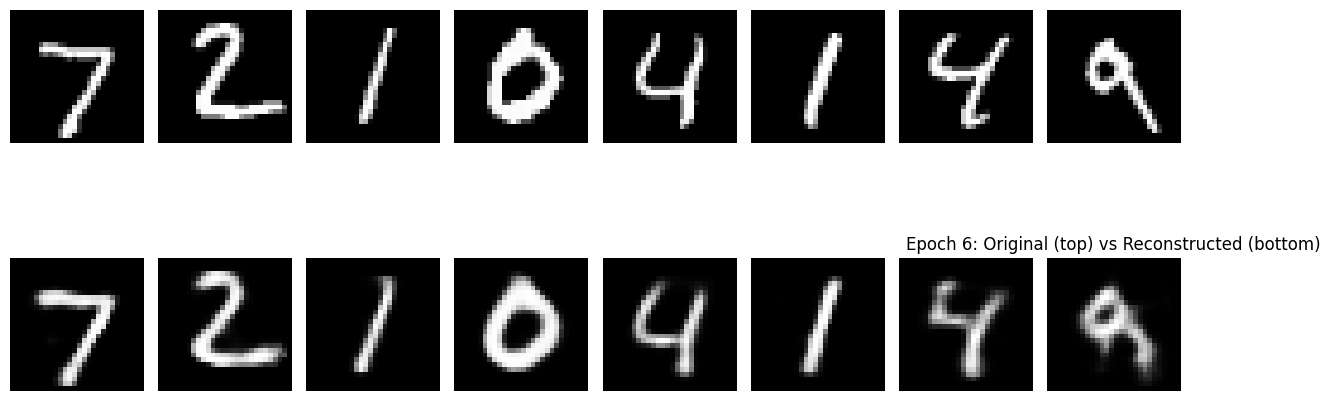

Train Epoch: 7 [0/60000 (0%)]	Loss: 111.847565
Train Epoch: 7 [12800/60000 (21%)]	Loss: 105.768936
Train Epoch: 7 [25600/60000 (43%)]	Loss: 109.661072
Train Epoch: 7 [38400/60000 (64%)]	Loss: 107.533020
Train Epoch: 7 [51200/60000 (85%)]	Loss: 105.889503
====> Epoch: 7 Average loss: 106.0355
====> Test set loss: 105.3660


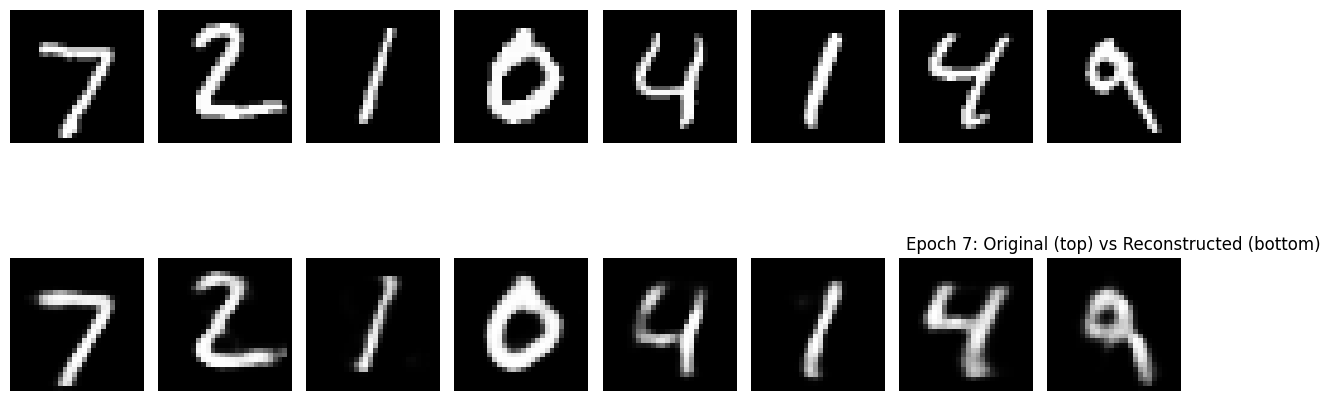

Train Epoch: 8 [0/60000 (0%)]	Loss: 104.877411
Train Epoch: 8 [12800/60000 (21%)]	Loss: 107.170197
Train Epoch: 8 [25600/60000 (43%)]	Loss: 107.383995
Train Epoch: 8 [38400/60000 (64%)]	Loss: 107.563461
Train Epoch: 8 [51200/60000 (85%)]	Loss: 107.244110
====> Epoch: 8 Average loss: 105.7230
====> Test set loss: 105.0908


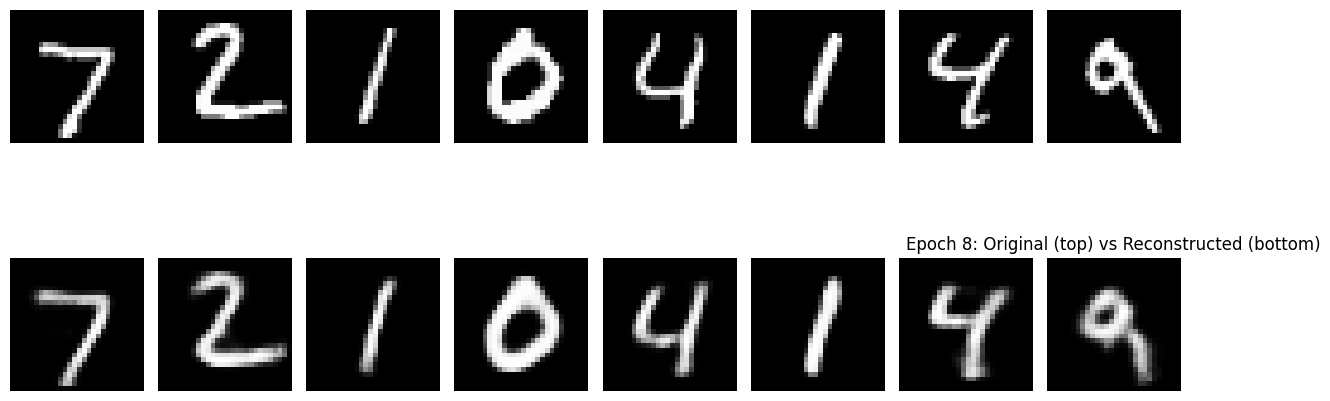

Train Epoch: 9 [0/60000 (0%)]	Loss: 105.027306
Train Epoch: 9 [12800/60000 (21%)]	Loss: 110.168991
Train Epoch: 9 [25600/60000 (43%)]	Loss: 101.756905
Train Epoch: 9 [38400/60000 (64%)]	Loss: 108.278015
Train Epoch: 9 [51200/60000 (85%)]	Loss: 102.371201
====> Epoch: 9 Average loss: 105.4821
====> Test set loss: 104.9199


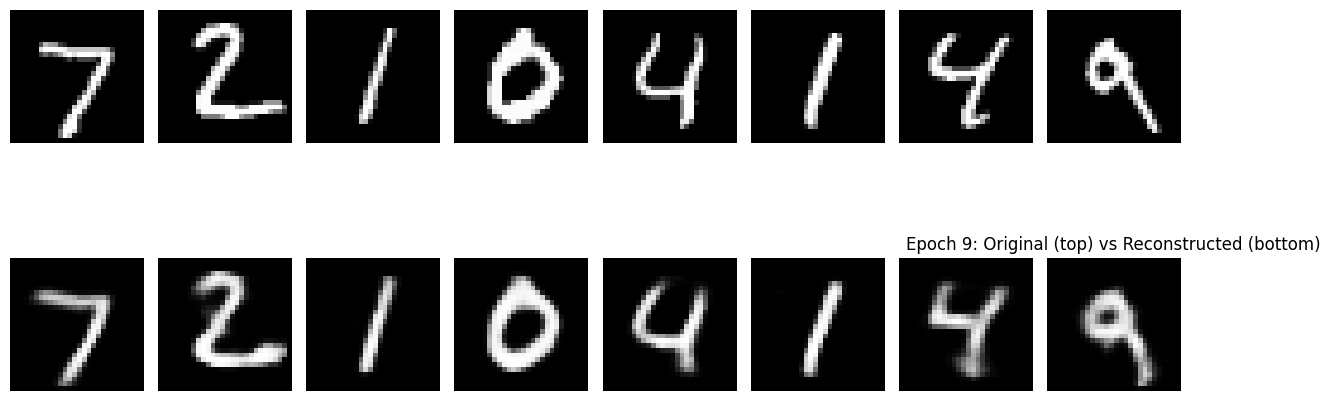

Train Epoch: 10 [0/60000 (0%)]	Loss: 100.699516
Train Epoch: 10 [12800/60000 (21%)]	Loss: 109.213455
Train Epoch: 10 [25600/60000 (43%)]	Loss: 106.362061
Train Epoch: 10 [38400/60000 (64%)]	Loss: 106.467941
Train Epoch: 10 [51200/60000 (85%)]	Loss: 104.624794
====> Epoch: 10 Average loss: 105.2121
====> Test set loss: 105.0197


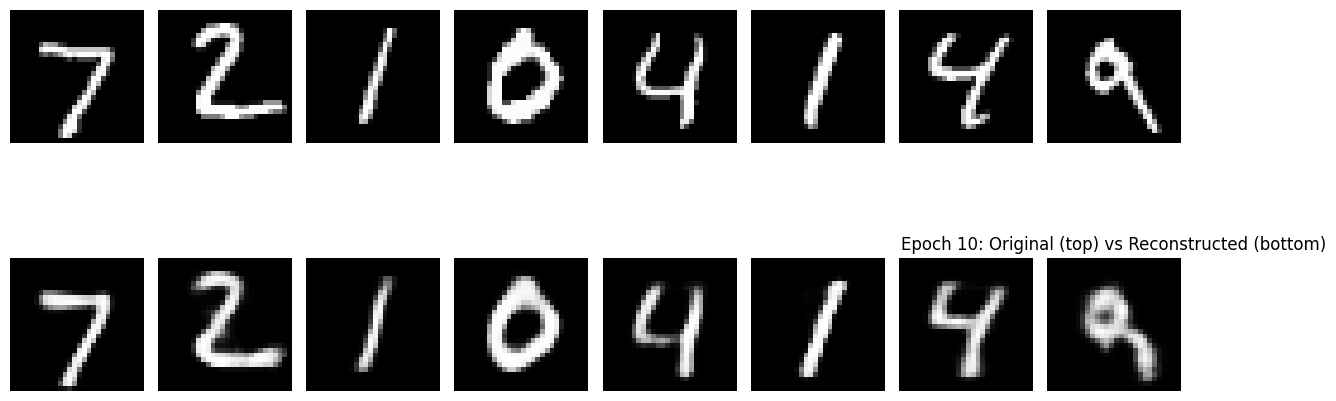

Train Epoch: 11 [0/60000 (0%)]	Loss: 106.299805
Train Epoch: 11 [12800/60000 (21%)]	Loss: 103.876419
Train Epoch: 11 [25600/60000 (43%)]	Loss: 101.116135
Train Epoch: 11 [38400/60000 (64%)]	Loss: 106.994461
Train Epoch: 11 [51200/60000 (85%)]	Loss: 102.882462
====> Epoch: 11 Average loss: 105.0262
====> Test set loss: 104.6189


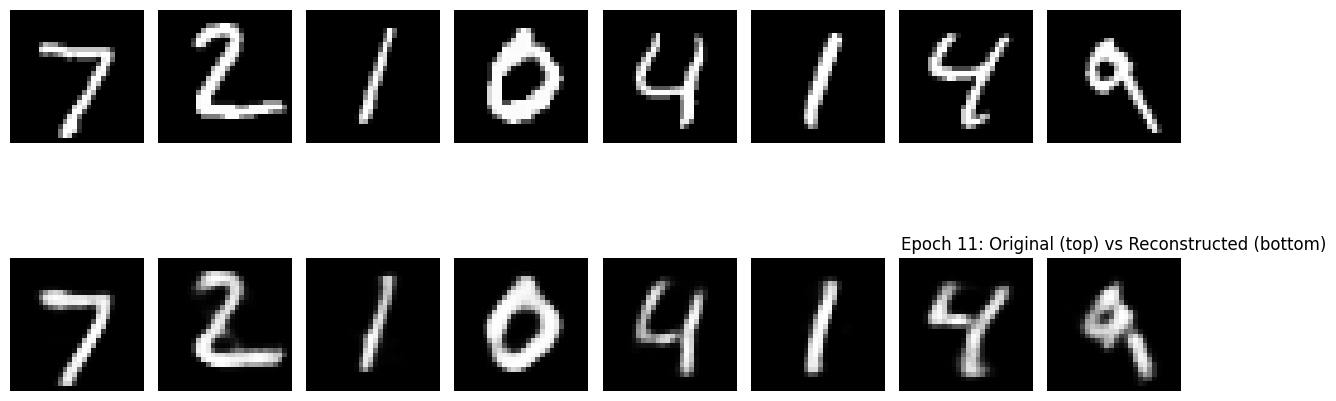

Train Epoch: 12 [0/60000 (0%)]	Loss: 104.025970
Train Epoch: 12 [12800/60000 (21%)]	Loss: 106.113205
Train Epoch: 12 [25600/60000 (43%)]	Loss: 104.140236
Train Epoch: 12 [38400/60000 (64%)]	Loss: 108.826797
Train Epoch: 12 [51200/60000 (85%)]	Loss: 101.064766
====> Epoch: 12 Average loss: 104.8169
====> Test set loss: 104.3415


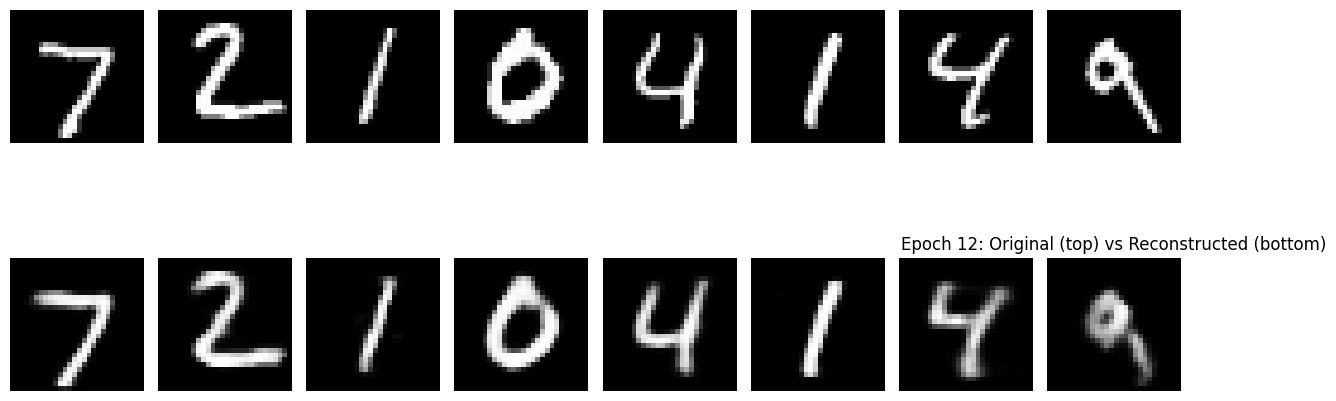

Train Epoch: 13 [0/60000 (0%)]	Loss: 102.811234
Train Epoch: 13 [12800/60000 (21%)]	Loss: 106.433563
Train Epoch: 13 [25600/60000 (43%)]	Loss: 104.394257
Train Epoch: 13 [38400/60000 (64%)]	Loss: 106.072235
Train Epoch: 13 [51200/60000 (85%)]	Loss: 107.309357
====> Epoch: 13 Average loss: 104.6163
====> Test set loss: 104.4581


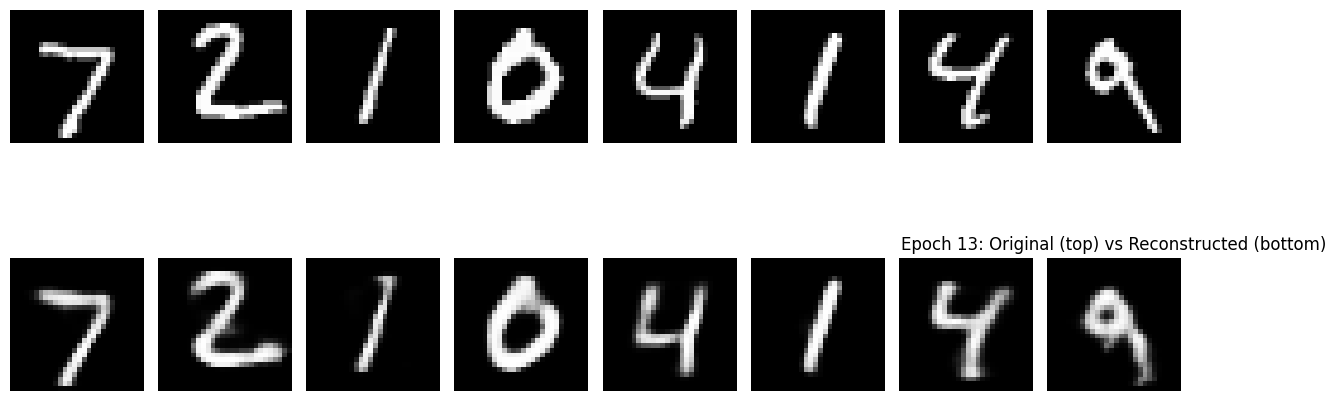

Train Epoch: 14 [0/60000 (0%)]	Loss: 104.174042
Train Epoch: 14 [12800/60000 (21%)]	Loss: 104.900566
Train Epoch: 14 [25600/60000 (43%)]	Loss: 106.509758
Train Epoch: 14 [38400/60000 (64%)]	Loss: 105.120743
Train Epoch: 14 [51200/60000 (85%)]	Loss: 106.673737
====> Epoch: 14 Average loss: 104.5041
====> Test set loss: 104.1543


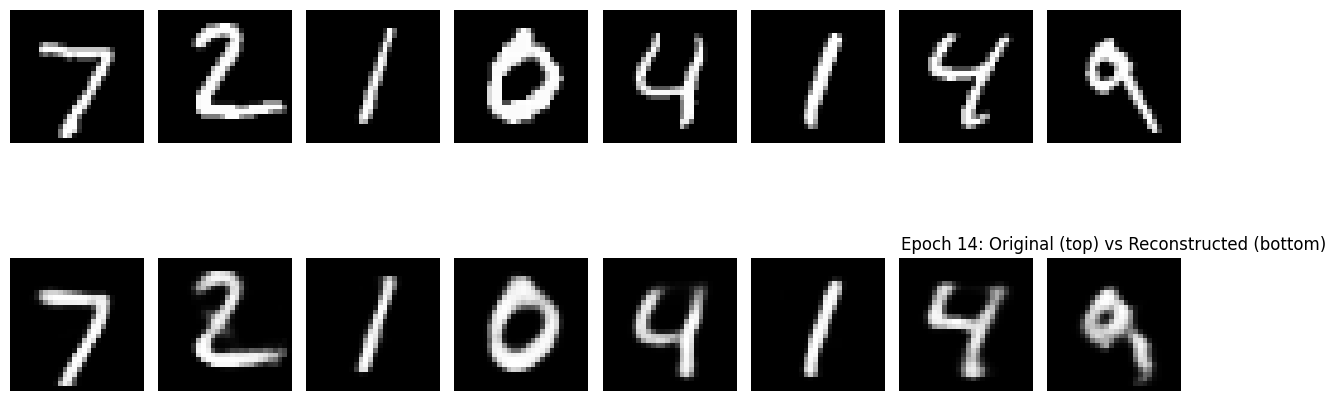

Train Epoch: 15 [0/60000 (0%)]	Loss: 106.360878
Train Epoch: 15 [12800/60000 (21%)]	Loss: 105.518417
Train Epoch: 15 [25600/60000 (43%)]	Loss: 104.651306
Train Epoch: 15 [38400/60000 (64%)]	Loss: 107.463943
Train Epoch: 15 [51200/60000 (85%)]	Loss: 105.950958
====> Epoch: 15 Average loss: 104.2945
====> Test set loss: 104.1077


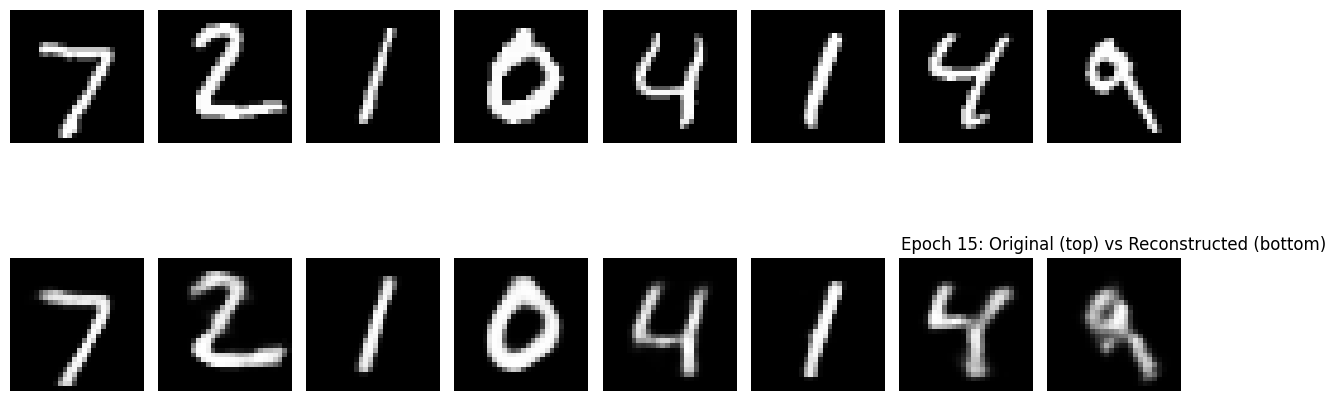

Train Epoch: 16 [0/60000 (0%)]	Loss: 98.590752
Train Epoch: 16 [12800/60000 (21%)]	Loss: 102.352066
Train Epoch: 16 [25600/60000 (43%)]	Loss: 100.896454
Train Epoch: 16 [38400/60000 (64%)]	Loss: 106.079262
Train Epoch: 16 [51200/60000 (85%)]	Loss: 104.199448
====> Epoch: 16 Average loss: 104.1733
====> Test set loss: 103.9366


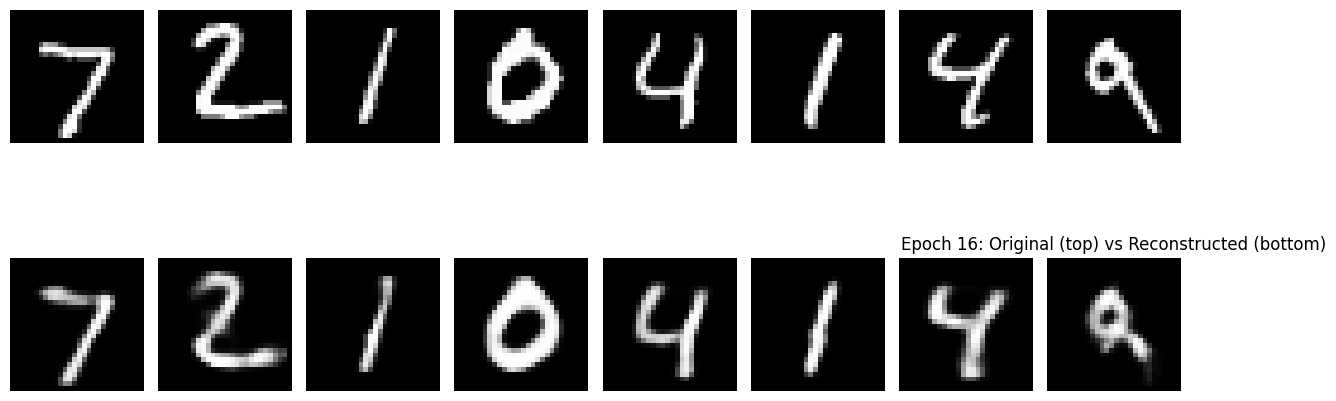

Train Epoch: 17 [0/60000 (0%)]	Loss: 105.334251
Train Epoch: 17 [12800/60000 (21%)]	Loss: 104.002808
Train Epoch: 17 [25600/60000 (43%)]	Loss: 105.527390
Train Epoch: 17 [38400/60000 (64%)]	Loss: 102.730392
Train Epoch: 17 [51200/60000 (85%)]	Loss: 105.491837
====> Epoch: 17 Average loss: 104.0252
====> Test set loss: 103.9111


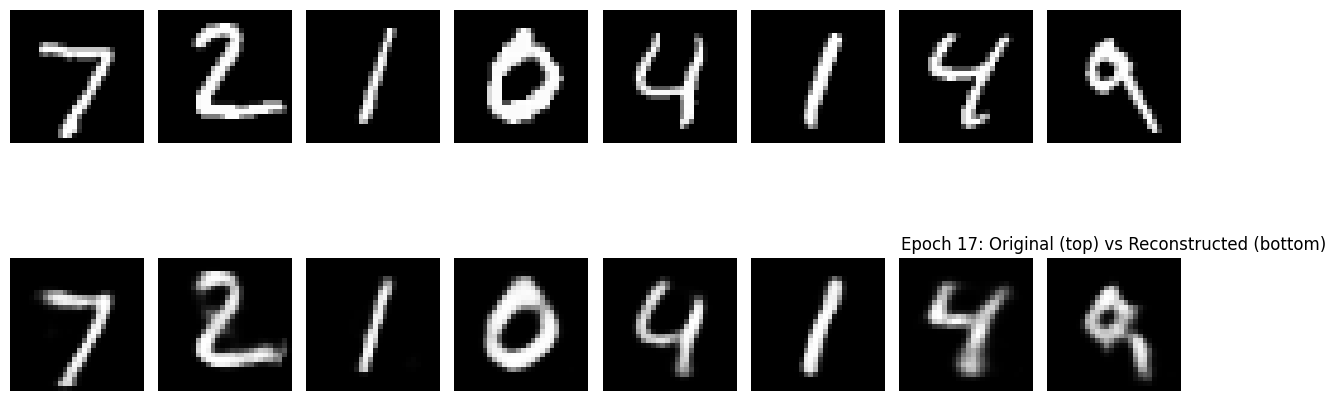

Train Epoch: 18 [0/60000 (0%)]	Loss: 101.136505
Train Epoch: 18 [12800/60000 (21%)]	Loss: 104.970215
Train Epoch: 18 [25600/60000 (43%)]	Loss: 103.984604
Train Epoch: 18 [38400/60000 (64%)]	Loss: 103.149460
Train Epoch: 18 [51200/60000 (85%)]	Loss: 102.365562
====> Epoch: 18 Average loss: 103.9058
====> Test set loss: 103.8796


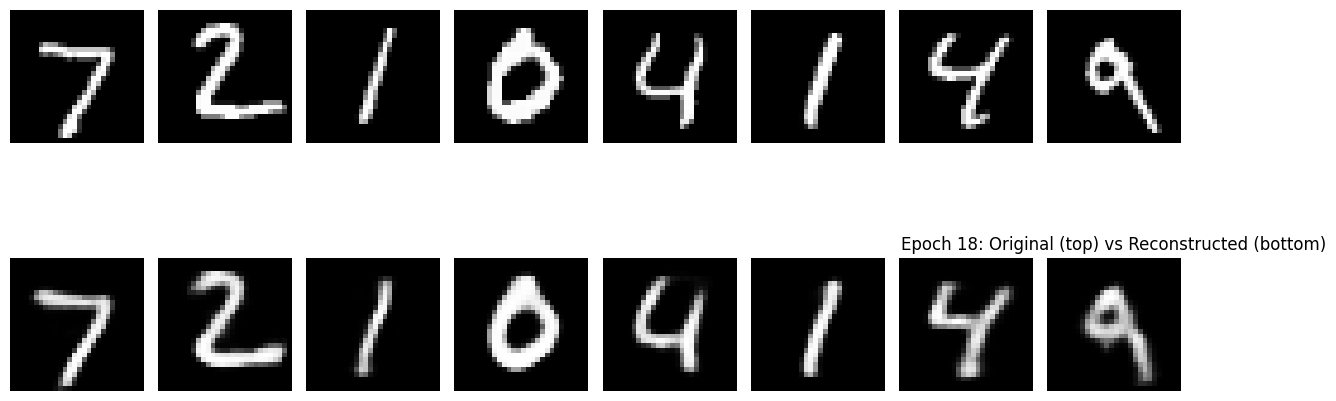

Train Epoch: 19 [0/60000 (0%)]	Loss: 103.369186
Train Epoch: 19 [12800/60000 (21%)]	Loss: 105.774452
Train Epoch: 19 [25600/60000 (43%)]	Loss: 103.937492
Train Epoch: 19 [38400/60000 (64%)]	Loss: 106.592209
Train Epoch: 19 [51200/60000 (85%)]	Loss: 102.650864
====> Epoch: 19 Average loss: 103.8072
====> Test set loss: 103.6199


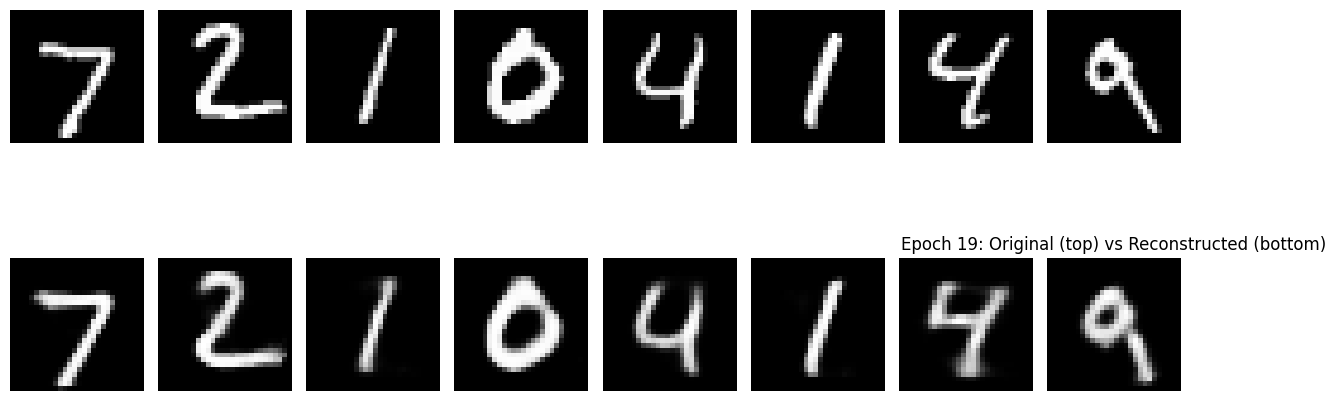

Train Epoch: 20 [0/60000 (0%)]	Loss: 103.366867
Train Epoch: 20 [12800/60000 (21%)]	Loss: 104.730118
Train Epoch: 20 [25600/60000 (43%)]	Loss: 105.296379
Train Epoch: 20 [38400/60000 (64%)]	Loss: 105.072632
Train Epoch: 20 [51200/60000 (85%)]	Loss: 109.426880
====> Epoch: 20 Average loss: 103.6690
====> Test set loss: 103.6847


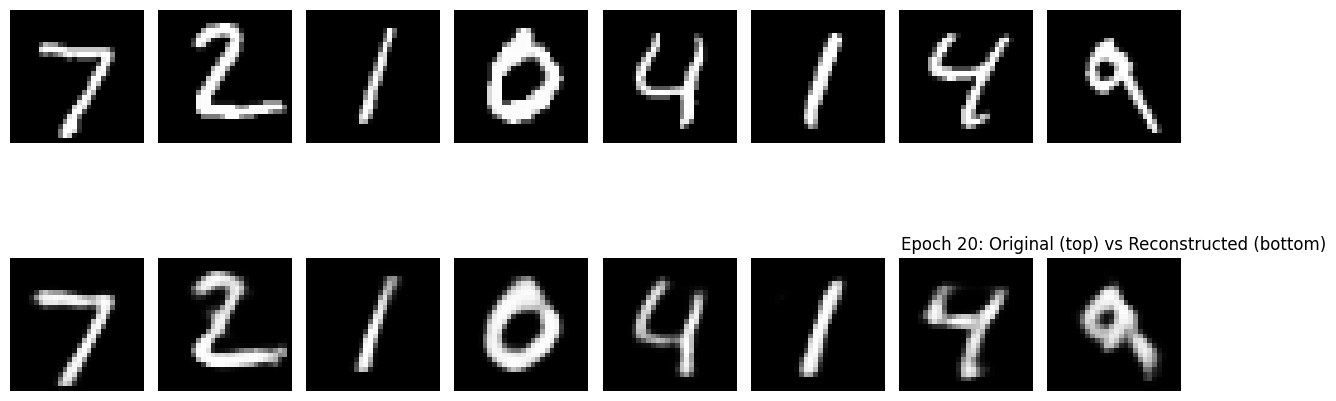

In [ ]:
train_losses = []
test_losses = []

for epoch in range(1, num_epochs + 1):
    train(epoch)
    test_loss = test(epoch)
    test_losses.append(test_loss)

    with torch.no_grad():
        sample = next(iter(test_loader))[0][:8].to(device)
        recon_sample, _, _ = model(sample)

        plt.figure(figsize=(12, 6))

        for i in range(8):
            # Original images
            plt.subplot(2, 8, i + 1)
            plt.imshow(sample[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.axis('off')

            # Reconstructed images
            plt.subplot(2, 8, i + 9)
            plt.imshow(recon_sample[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.axis('off')

        plt.title(f'Epoch {epoch}: Original (top) vs Reconstructed (bottom)')
        plt.tight_layout()
        plt.show()

In [ ]:
def generate_samples(num_samples=10):
    with torch.no_grad():
        # Sample from the latent space
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decode(z)

        plt.figure(figsize=(12, 3))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(samples[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.axis('off')

        plt.title('Generated Samples from Random Latent Vectors')
        plt.tight_layout()
        plt.show()

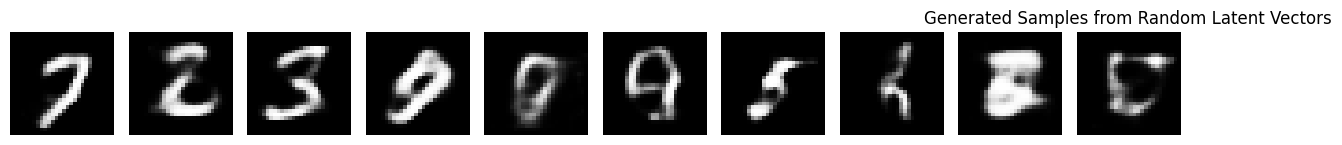

In [ ]:
generate_samples(10)

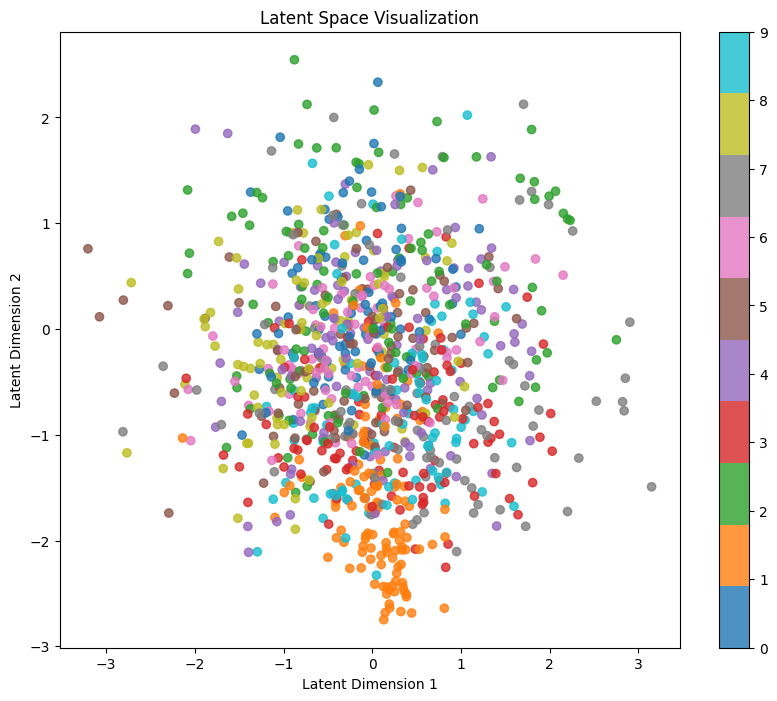

In [ ]:
# Plot latent space (first 2 dimensions)
def visualize_latent_space():
    model.eval()
    with torch.no_grad():
        test_data = []
        test_labels = []
        for data, labels in test_loader:
            test_data.append(data)
            test_labels.append(labels)
        test_data = torch.cat(test_data, dim=0).to(device)
        test_labels = torch.cat(test_labels, dim=0).to(device)

        mu, _ = model.encode(test_data.view(test_data.size(0), -1))

        mu = mu[:1000].cpu().numpy()
        labels = test_labels[:1000].cpu().numpy()

        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(mu[:, 0], mu[:, 1], c=labels, cmap='tab10', alpha=0.8)
        plt.colorbar(scatter)
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        plt.title('Latent Space Visualization')
        plt.show()
visualize_latent_space()

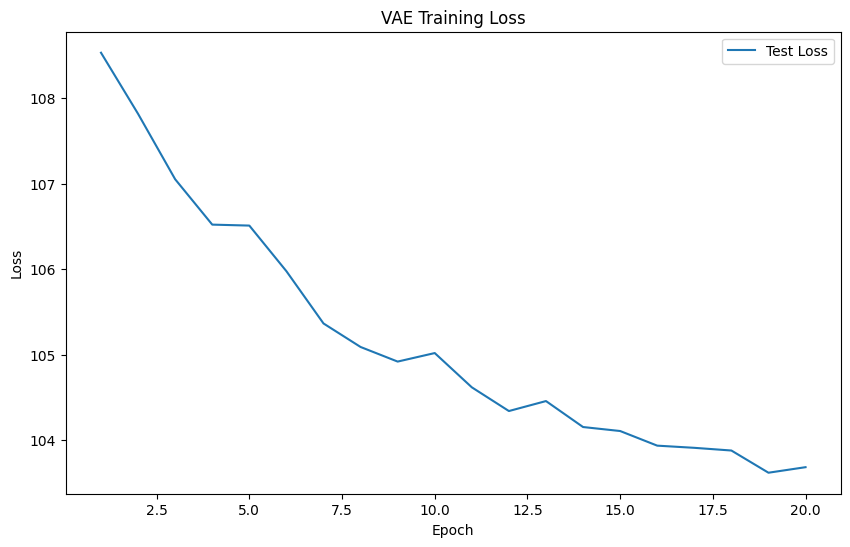

In [ ]:
# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.legend()
plt.show()

##Variational Autoencoder Follow-Up Assignment
Overview

In this follow-up assignment, you will apply the Variational Autoencoder (VAE) concepts we've learned to a new dataset. You'll implement, train, and evaluate a VAE model on the Fashion-MNIST dataset, which contains grayscale images of clothing items.

####Learning Objectives

Apply VAE architecture to a different dataset

Compare reconstruction quality across different domains

Experiment with the latent space dimension

Explore the impact of hyperparameters on model performance

####Dataset
Use the Fashion-MNIST dataset, which consists of 28×28 grayscale images of 10 fashion categories:

0: T-shirt/top

1: Trouser

2: Pullover

3: Dress

4: Coat

5: Sandal

6: Shirt

7: Sneaker

8: Bag

9: Ankle boot

Tasks
1. Data Preparation

Load the Fashion-MNIST dataset using torchvision

Create appropriate data loaders for training and testing

Visualize a batch of training examples

2. VAE Implementation

Modify the VAE architecture to work with Fashion-MNIST

Experiment with at least one of the following:

Different latent dimensions (try 2, 10, and 50)

Different hidden layer sizes

Additional hidden layers in encoder/decoder



3. Training

Train your VAE for at least 10 epochs

Plot the training and validation loss curves

Save your best model based on validation loss

4. Evaluation (25 points)

Visualize original vs. reconstructed images

Generate new fashion items by sampling from the latent space

Visualize the latent space distribution (if using latent_dim=2)

Calculate and report reconstruction loss metrics

5. Analysis (20 points)

Compare the VAE's performance on Fashion-MNIST vs. MNIST

Discuss which types of clothing items are reconstructed better/worse

Analyze how the latent dimension affects reconstruction quality and generation capabilities



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128
learning_rate = 1e-3
num_epochs = 10
latent_dim = # TODO: Experiment with different values

# TODO: Load Fashion-MNIST dataset

# TODO: Implement VAE model

# TODO: Define loss function

# TODO: Implement training loop

# TODO: Implement evaluation methods

# TODO: Analyze results